## Projeto 4 Redes Complexas
    Fernando Soares de Aguiar Neto  (7152184)
    Guiherme Guilherme Milan Santos (9012966)


### Imports e Funções

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import math
from networkx.algorithms.community.community_generators import LFR_benchmark_graph

In [105]:
def printInfo(graph):
    N = len(graph)
    M = graph.number_of_edges()
    print('Nós:', N)
    print('Arestas:', M)
    print('Grau Médio:', 2*M/N)

def set_ax_fontsize(ax, fontsize):
    ax.title.set_fontsize(fontsize)
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    [tick.set_fontsize(fontsize) for tick in ax.get_xticklabels()];
    [tick.set_fontsize(fontsize) for tick in ax.get_yticklabels()];

def failures(H):
    G = H.copy()
    
    N0 = len(G)
    vn = [] #percentage of removed nodes
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > int(0.01*N0)):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = random.choice(list(G.nodes())) #select the node on the largest component
        #print('selected to removed:', node)
        G.remove_node(node) 
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0] 
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn

    
def most_connected(G): # This function is used to find the most connected node
    maxk = 0
    node = 0
    for i in G.nodes():
        if(G.degree(i) >= maxk):
            maxk = G.degree(i)
            node = i
    return node 

def attacks(H):
    G = H.copy()
    from random import choice
    N0 = len(G)
    vn = []
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > int(0.01*N0)):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = most_connected(G) #select the most connected node on the largest component            
        #print('selected to removed:', node)
        G.remove_node(node) 
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0] 
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn

def find(v, i): # function to find the positions of an element in a vector
    l = []
    pos = 0
    for x in v:
        if(x == i):
            l.append(pos)
        pos = pos + 1
    return l

def SIRNodesRecovered(G, beta=0.5, mu=1, Tmax = 20, rep=30):
    av_rho = np.zeros(Tmax)
    nRecovered = []
    N = len(G.nodes())
    for seed_node in G.nodes():
        meanRecovered = 0
        for r in range(0,rep):
            vector_states = np.zeros(N) # vector that stores the states of the vertices
            vector_states[seed_node] = 1 # vector that stores the states
            ninfected = 1
            t = 0 # start in t= 0 
            infected = list() # Stores the number of infected nodes at each time step
            vt = list() #store the time step
            vrho = list()
            # Reactive model
            while ninfected > 0: # Simulate while we can find infected nodes
                infected = find(vector_states,1) # list of infected nodes
                for i in infected: # try to infect the neighbors
                    neigs = G.neighbors(i)
                    for j in neigs:
                        if np.random.rand() < beta:
                            if(vector_states[j] != 2): # verify if the node is not recovered
                                vector_states[j] = 1
                for k in infected: # try to recover the infected nodes
                    if np.random.rand() < mu:
                        vector_states[k] = 2
                ninfected = len(find(vector_states,1))
                vrho.append(ninfected/N)
                t = t + 1
                vt.append(t)
            for x in range(0, min(len(vrho),Tmax)):
                av_rho[x] = av_rho[x] + vrho[x]
            
            meanRecovered = meanRecovered + (len(find(vector_states,2))/rep)
        
        nRecovered.append(meanRecovered)

    nRecovered = np.array(nRecovered)/N
    return nRecovered
    
            
def SIRlbda(G, betaRange=np.arange(0, 1, 0.05), mu=1, Tmax = 20):
    vlbda = list()
    rhoI = list() # vector that stores the fraction of infected nodes according to the parameter lambda
    N = len(G.nodes())
    for beta in betaRange:
        lbd = beta/mu
        #Reactive process: SIR dynamics
        av_rho = np.zeros(Tmax)
        for seed_node in G.nodes():
            vector_states = np.zeros(N) # vector that stores the states of the vertices
            vector_states[seed_node] = 1 # vector that stores the states
            ninfected = 1
            t = 0 # start in t= 0 
            infected = list() # Stores the number of infected nodes at each time step
            vt = list() #store the time step
            vrho = list()
            # Reactive model
            while ninfected > 0: # Simulate while we can find infected nodes
                infected = find(vector_states,1) # list of infected nodes
                for i in infected: # try to infect the neighbors
                    neigs = G.neighbors(i)
                    for j in neigs:
                        if np.random.rand() < beta:
                            if(vector_states[j] != 2): # verify if the node is not recovered
                                vector_states[j] = 1
                for k in infected: # try to recover the infected nodes
                    if np.random.rand() < mu:
                        vector_states[k] = 2
                ninfected = len(find(vector_states,1))
                vrho.append(ninfected/N)
                t = t + 1
                vt.append(t)
            for x in range(0, min(len(vrho),Tmax)):
                av_rho[x] = av_rho[x] + vrho[x]

        av_rho = av_rho/len(G.nodes())
        rhoI.append(np.mean(av_rho[np.arange(int(0.8*Tmax), Tmax)]))
        vlbda.append(lbd)
        
    return vlbda, rhoI

def SISlbda(G, betaRange=np.arange(0, 1, 0.05), mu=1, Tmax = 20):
    N = len(G.nodes())
    vlbda = list()
    rhoI = list() # vector that stores the fraction of infected nodes according to the parameter lambda
    for beta in betaRange:
        lbd = beta/mu
        av_rho = np.zeros(Tmax)
        for seed_node in G.nodes():
            vector_states = np.zeros(N) # vector that stores the states of the vertices
            vector_states[seed_node] = 1 # vector that stores the states
            ninfected = 1
            infected = list() # Stores the number of infected nodes at each time step
            vrho = list()
            # Reactive model
            for t in np.arange(0, Tmax): # Simulate until a maximum number of steps Tmax
                infected = find(vector_states,1) # list of infected nodes
                for i in infected: # try to infect the neighbors
                    neigs = G.neighbors(i)
                    for j in neigs:
                        if np.random.rand() < beta:
                            vector_states[j] = 1
                for k in infected: # try to recover the infected nodes
                    if np.random.rand() < mu:
                        vector_states[k] = 0
                ninfected = len(find(vector_states,1))
                vrho.append(ninfected/N)
            for x in range(0, len(vrho)):
                av_rho[x] = av_rho[x] + vrho[x]
        av_rho = av_rho/len(G.nodes())
        rhoI.append(np.mean(av_rho[np.arange(int(0.8*Tmax), Tmax)]))
        vlbda.append(lbd)
    return vlbda, rhoI
        
def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes():
            M = M + G.degree(i)**m
        M = M/N
        return M

def fcritical(G):
    f = 1 - 1/(momment_of_degree_distribution(G,2)/momment_of_degree_distribution(G,1) - 1)
    return f

def lbdaCritical(G):
    lambda_c = momment_of_degree_distribution(G,1)/momment_of_degree_distribution(G,2)
    return lambda_c

def betweenessCentrality(graph):
    x = dict(nx.betweenness_centrality(graph))
    x = pd.Series(x)
    return x

def closenessCentrality(graph):
    x = dict(nx.closeness_centrality(graph))
    x = pd.Series(x)
    return x

def communicabilityCentrality(graph):
    x = pd.DataFrame(nx.communicability_exp(graph))
    x = pd.Series(np.diag(x))
    return x

def degrees(graph):
    x = dict(nx.degree(graph))
    x = pd.Series(x)
    return x

def eigenVectorCentrality(graph,max_iter=100):
    x = dict(nx.eigenvector_centrality(graph, max_iter=max_iter))
    x = pd.Series(x)
    return x

def kCore(graph):
    x = dict(nx.core_number(graph))
    x = pd.Series(x)
    return x

def knnDegree(graph):
    x = dict(nx.average_degree_connectivity(graph))
    degrees = pd.Series(list(x.keys()))
    knn = pd.Series(list(x.values()))
    return degrees, knn

def pageRank(graph, alpha=0.85):
    x = dict(nx.pagerank(graph, alpha=alpha))
    x = pd.Series(x)
    return x

## Exercício 1

In [3]:
rep = 15
largeCompSizeFailure = dict()
largeCompSizeAttack = dict()
fc =  dict()
percentil = dict()
av_degree = 10
n = 350
p = av_degree/(n-1)


#ER
er = nx.gnp_random_graph(n=n, p=p, seed=None, directed=False)
s, vn = failures(er)
size = len(vn)

S = np.zeros(size)
Atq = np.zeros(size)
p = av_degree/(n-1)
fc['ER'] = 0
for i in range(rep):
    er = nx.gnp_random_graph(n=n, p=p, seed=None, directed=False)
    s, vn = failures(er)
    S = S + s
    atq, vn = attacks(er)
    Atq = Atq + atq
    Fc = fcritical(er)
    fc['ER'] = fc['ER'] + Fc
    
fc['ER'] = fc['ER']/rep    
largeCompSizeFailure['ER'] = S/rep#np.mean(S, axis=0)
largeCompSizeAttack['ER'] = Atq/rep
percentil['ER'] = vn

#BA
fc['BA'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
m = int(av_degree/2)
for i in range(rep):
    ba = nx.barabasi_albert_graph(n, m)
    s, vn = failures(ba)
    S = S + s
    atq, vn = attacks(ba)
    Atq = Atq + atq
    Fc = fcritical(ba)
    fc['BA'] = fc['BA'] + Fc
    
fc['BA'] = fc['BA']/rep  
largeCompSizeFailure['BA'] = S/rep
largeCompSizeAttack['BA'] = Atq/rep
percentil['BA'] = vn

#SW 10E-3
fc['SW10E-3'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
p = 0.001 #probability of rewiring
for i in range(rep):
    sw = nx.watts_strogatz_graph(n, av_degree, p, seed=None)
    s, vn = failures(sw)
    S = S + s
    atq, vn = attacks(sw)
    Atq = Atq + atq
    Fc = fcritical(sw)
    fc['SW10E-3'] = fc['SW10E-3'] + Fc
    
fc['SW10E-3'] = fc['SW10E-3']/rep         
largeCompSizeFailure['SW10E-3'] = S/rep
largeCompSizeAttack['SW10E-3'] = Atq/rep
percentil['SW10E-3'] = vn

#SW 10E-2
fc['SW10E-2'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
p = 0.01 #probability of rewiring
for i in range(rep):
    sw = nx.watts_strogatz_graph(n, av_degree, p, seed=None)
    s, vn = failures(sw)
    S = S + s
    atq, vn = attacks(sw)
    Atq = Atq + atq
    Fc = fcritical(sw)
    fc['SW10E-2'] = fc['SW10E-2'] + Fc
    
fc['SW10E-2'] = fc['SW10E-2']/rep     
largeCompSizeFailure['SW10E-2'] = S/rep
largeCompSizeAttack['SW10E-2'] = Atq/rep
percentil['SW10E-2'] = vn

#SW 10E-1
fc['SW10E-1'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
p = 0.1 #probability of rewiring
for i in range(rep):
    sw = nx.watts_strogatz_graph(n, av_degree, p, seed=None)
    s, vn = failures(sw)
    S = S + s
    atq, vn = attacks(sw)
    Atq = Atq + atq
    Fc = fcritical(sw)
    fc['SW10E-1'] = fc['SW10E-1'] + Fc
    
fc['SW10E-1'] = fc['SW10E-1']/rep 
largeCompSizeFailure['SW10E-1'] = S/rep
largeCompSizeAttack['SW10E-1'] = Atq/rep
percentil['SW10E-1'] = vn

#Regular WS
fc['WS1'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
p = 0 #probability of rewiring
for i in range(rep):
    sw = nx.watts_strogatz_graph(n, av_degree, p, seed=None)
    s, vn = failures(sw)
    S = S + s
    atq, vn = attacks(sw)
    Atq = Atq + atq
    Fc = fcritical(sw)
    fc['WS1'] = fc['WS1'] + Fc
    
fc['WS1'] = fc['WS1']/rep 
largeCompSizeFailure['WS1'] = S/rep
largeCompSizeAttack['WS1'] = Atq/rep
percentil['WS1'] = vn

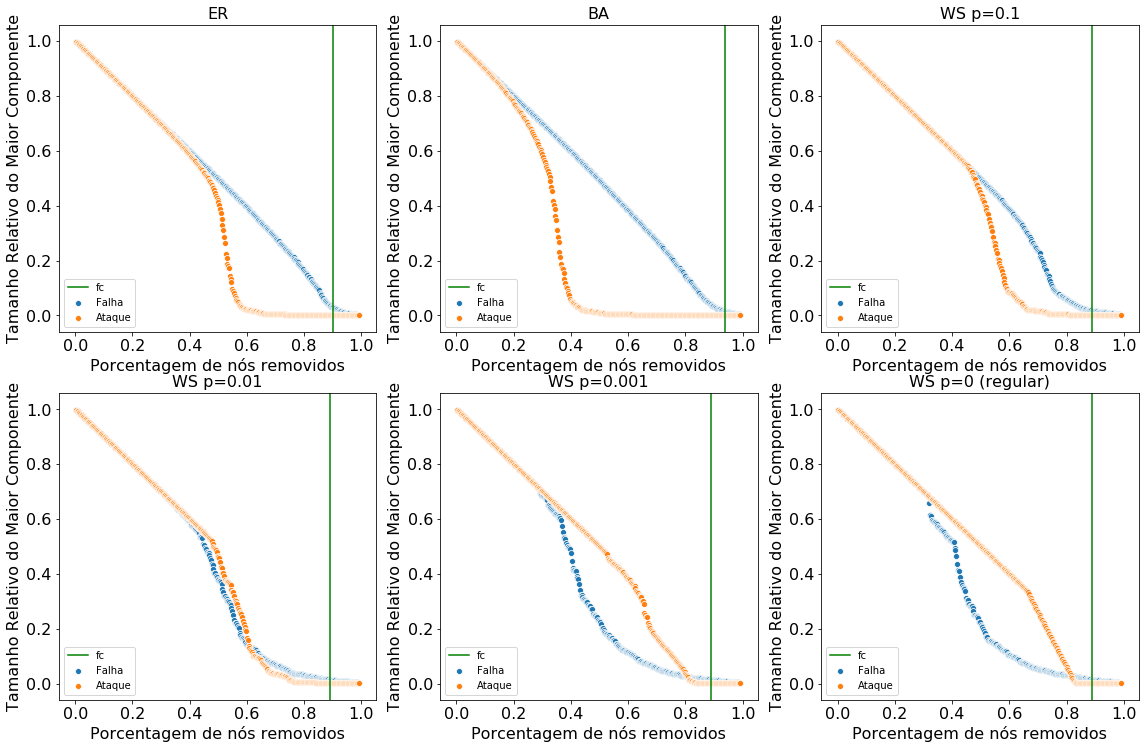

In [4]:
fig, axis = plt.subplots(2,3, figsize=(8,5))
l,c = 0,0
n = 0
for rede, title in [('ER','ER'),('BA','BA'),('SW10E-1','WS p=0.1'),('SW10E-2','WS p=0.01'),('SW10E-3','WS p=0.001'),('WS1','WS p=0 (regular)')]:

    plt.subplots_adjust(right=2, top=2)
    axis[l,c].set_xlabel('Porcentagem de nós removidos')
    axis[l,c].set_ylabel('Tamanho Relativo do Maior Componente')
    axis[l,c].set_title(title)
    set_ax_fontsize(axis[l,c], 16)
    axis[l,c].axvline(x=fc[rede], color = 'g', label='fc')
    sns.scatterplot(x=percentil[rede], y=largeCompSizeFailure[rede], ax=axis[l,c], label='Falha')
    sns.scatterplot(x=percentil[rede], y=largeCompSizeAttack[rede], ax=axis[l,c], label='Ataque')
    n = n+1
    l = math.floor(n/3)
    c = (n) % 3

Utilizamos a média de 15 repetições das redes.
Notamos que as redes smal world, tendem a ser mais robustas, tanto a ataques quanto falhas, provavelmente dada a complexidade da sua estrutura. Por sua vez redes livres de escala, ainda que sejam resilientes a falhas, são muito suscetíveis a ataques direcionados, uma vez que os hubs acabam sendo responsáveis por ligar diversas 'regiões' da rede. Por fim, as redes ER apresentam resiliencia maior a ataques em comparação com as BA, devido a não existir prioridades na escolha de novas arestas, desfavorecendo a criação de hubs.

## Para redes reais.

In [5]:
#Human Protein
protein = nx.read_edgelist("../datasets/out.maayan-vidal", comments='%')
protein = max(nx.connected_component_subgraphs(protein), key=len)
protein = protein.to_undirected()
protein.remove_edges_from(nx.selfloop_edges(protein))
protein = nx.convert_node_labels_to_integers(protein, first_label=0)
print("\n\nHuman Protein")
printInfo(protein)

# c-elegans 2007
celegans2007 = nx.read_edgelist('../datasets/C-elegans-2007.txt')
celegans2007 = celegans2007.to_undirected()
celegans2007.remove_edges_from(nx.selfloop_edges(celegans2007))
celegans2007 = max(nx.connected_component_subgraphs(celegans2007), key=len)
celegans2007 = nx.convert_node_labels_to_integers(celegans2007, first_label=0)
print("\n\nC-Elegans 2007")
printInfo(celegans2007)

#mosquito
mosquito = nx.read_edgelist('../datasets/mosquito.csv')
mosquito = mosquito.to_undirected()
mosquito = max(nx.connected_component_subgraphs(mosquito), key=len)
mosquito = nx.convert_node_labels_to_integers(mosquito, first_label=0)
print("\n\nMosquito")
printInfo(mosquito)




Human Protein
Nós: 2783
Arestas: 6007
Grau Médio: 4.316924182536831


C-Elegans 2007
Nós: 1108
Arestas: 1500
Grau Médio: 2.707581227436823


Mosquito
Nós: 6162
Arestas: 64380
Grau Médio: 20.895813047711783


In [6]:
fc = dict()
failure = dict()
attack = dict()
percentil = dict()

#protein
failure['protein'], percentil['protein'] = failures(protein)
attack['protein'], percentil['protein'] = attacks(protein)
fc['protein'] = fcritical(protein)

# c-elegans 2007
failure['celegans'], percentil['celegans'] = failures(celegans2007)
attack['celegans'], percentil['celegans'] = attacks(celegans2007)
fc['celegans'] = fcritical(celegans2007)

#mosquito
fc['mosquito'] = 0
failure['mosquito'], percentil['mosquito'] = failures(mosquito)
attack['mosquito'], percentil['mosquito'] = attacks(mosquito)
fc['mosquito'] = fcritical(mosquito)

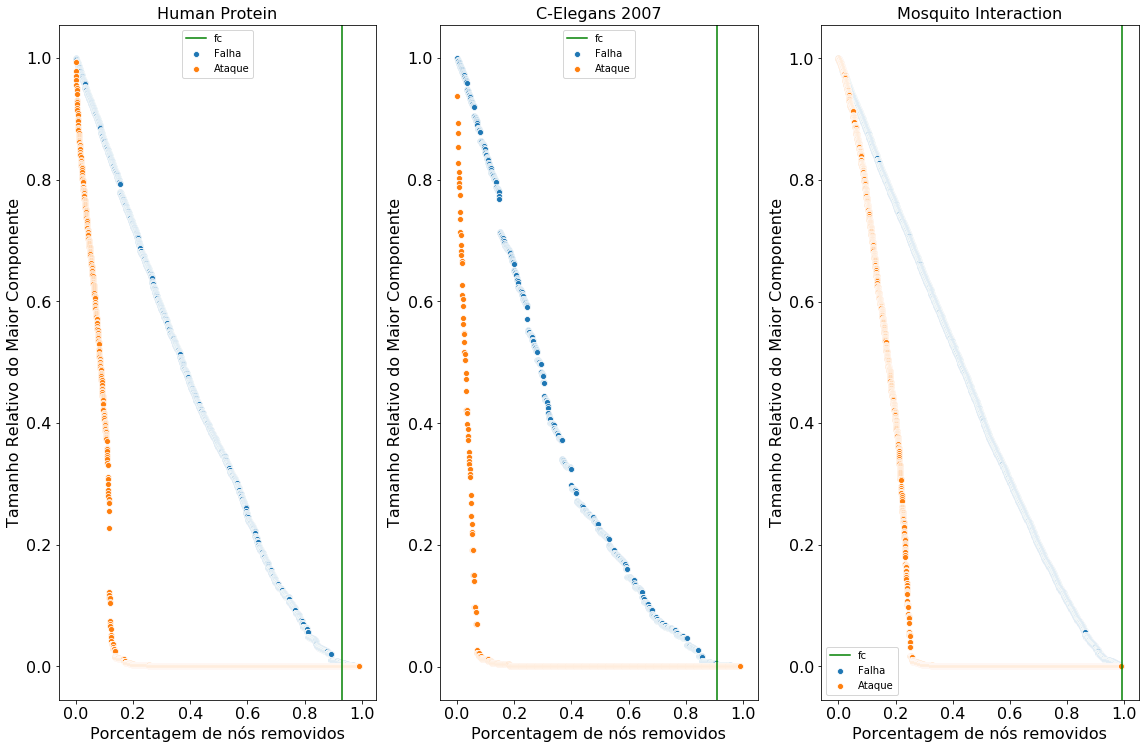

In [8]:
fig, axis = plt.subplots(1,3, figsize=(8,5))
n = 0
for rede, title in [('protein','Human Protein'),('celegans','C-Elegans 2007'),('mosquito','Mosquito Interaction')]:

    plt.subplots_adjust(right=2, top=2)
    axis[n].set_xlabel('Porcentagem de nós removidos')
    axis[n].set_ylabel('Tamanho Relativo do Maior Componente')
    axis[n].set_title(title)
    set_ax_fontsize(axis[n], 16)
    axis[n].axvline(x=fc[rede], color = 'g', label='fc')
    sns.scatterplot(x=percentil[rede], y=failure[rede], ax=axis[n], label='Falha')
    sns.scatterplot(x=percentil[rede], y=attack[rede], ax=axis[n], label='Ataque')
    n = n+1


As três redes apresentam uma baixa resistência a ataques, provavelmente devido a serem livres de escala. Entre elas, a rede de interação de mosquitos é a que apresenta maior resistência a ataques, precisando de pouco mais de 20% dos nós removidos via ataques para quebrar completamente. Interessante notar que as redes livres de escala reais são ainda mais suscetíveis a ataques que as redes Barabasi-Albert geradas anteriormente.

## Efeito de Comunidade

In [13]:
N = 128
tau1 = 3
tau2 = 1.5
k =16
minc = 16
maxc = 16

rep = 15
largeCompSizeFailure = dict()
largeCompSizeAttack = dict()
fc =  dict()
percentil = dict()

#getting vn size
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = 0.1, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc)
s, vn = failures(G)
size = len(vn)

#Mu = 0.1
for mu in [0.1, 0.3, 0.5]:
    fc[mu] = 0
    S = np.zeros(size)
    Atq = np.zeros(size)
    for i in range(rep):
        G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                            max_degree = k, min_community=minc, max_community = maxc)
        s, vn = failures(G)
        S = S + s
        atq, vn = attacks(G)
        Atq = Atq + atq
        Fc = fcritical(G)
        fc[mu] = fc[mu]+ Fc

    fc[mu] = fc[mu]/rep 
    largeCompSizeFailure[mu] = S/rep
    largeCompSizeAttack[mu] = Atq/rep
    percentil[mu] = vn

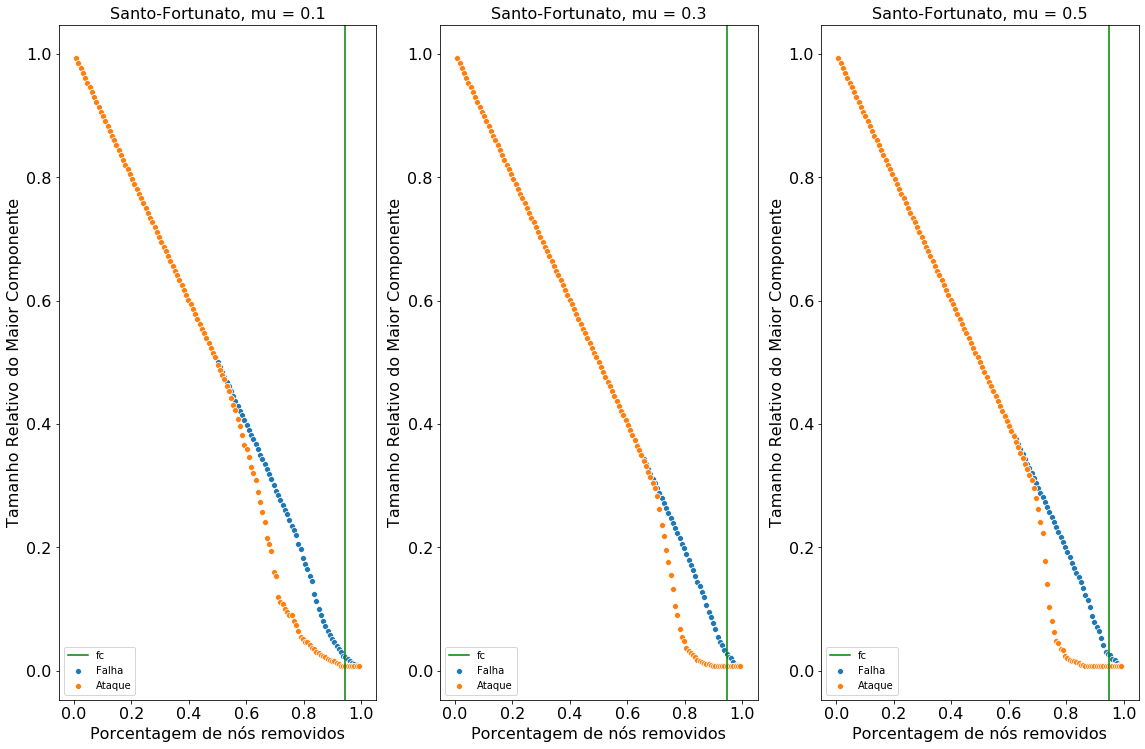

In [17]:
fig, axis = plt.subplots(1,3, figsize=(8,5))
n = 0
for mu in [0.1, 0.3, 0.5]:
    plt.subplots_adjust(right=2, top=2)
    axis[n].set_xlabel('Porcentagem de nós removidos')
    axis[n].set_ylabel('Tamanho Relativo do Maior Componente')
    axis[n].set_title('Santo-Fortunato, mu = '+str(mu))
    set_ax_fontsize(axis[n], 16)
    axis[n].axvline(x=fc[mu], color = 'g', label='fc')
    sns.scatterplot(x=percentil[mu], y=largeCompSizeFailure[mu], ax=axis[n], label='Falha')
    sns.scatterplot(x=percentil[mu], y=largeCompSizeAttack[mu], ax=axis[n], label='Ataque')
    n = n+1

Redes com estrutura de comunidade tendem a ser bem resistentes, tanto a ataques quanto a falhas. Conforme mu aumenta as redes tendem a ser mais resilientes a ataques.

## Exercício 2

In [4]:
av_degree = 8
n = 500
p = av_degree/(n)

#ER
er = nx.gnp_random_graph(n=n, p=p, seed=None, directed=False)

#BA
m = int(av_degree/2)
ba = nx.barabasi_albert_graph(n, m)

#SW 10E-3
pr = 0.001 #probability of rewiring
sw_e3= nx.watts_strogatz_graph(n, av_degree, pr, seed=None)
    
#SW 10E-2
pr = 0.01 #probability of rewiring
sw_e2 = nx.watts_strogatz_graph(n, av_degree, pr, seed=None)

#SW 10E-1
pr = 0.1 #probability of rewiring
sw_e1 = nx.watts_strogatz_graph(n, av_degree, pr, seed=None)

#Regular WS
pr = 0 #probability of rewiring
reg = nx.watts_strogatz_graph(n, av_degree, pr, seed=None)

### SIR analysis

In [7]:
betaRange = np.arange(0,1,0.05)
Tmax = 30
I = dict()
lbdaAll = betaRange # considering mu=1, otherwise it must be divided by mu.
for G in [er, ba, sw_e3, sw_e2, sw_e1, reg]:
        _, I[G] = SIRlbda(G, betaRange, mu=1, Tmax=Tmax)


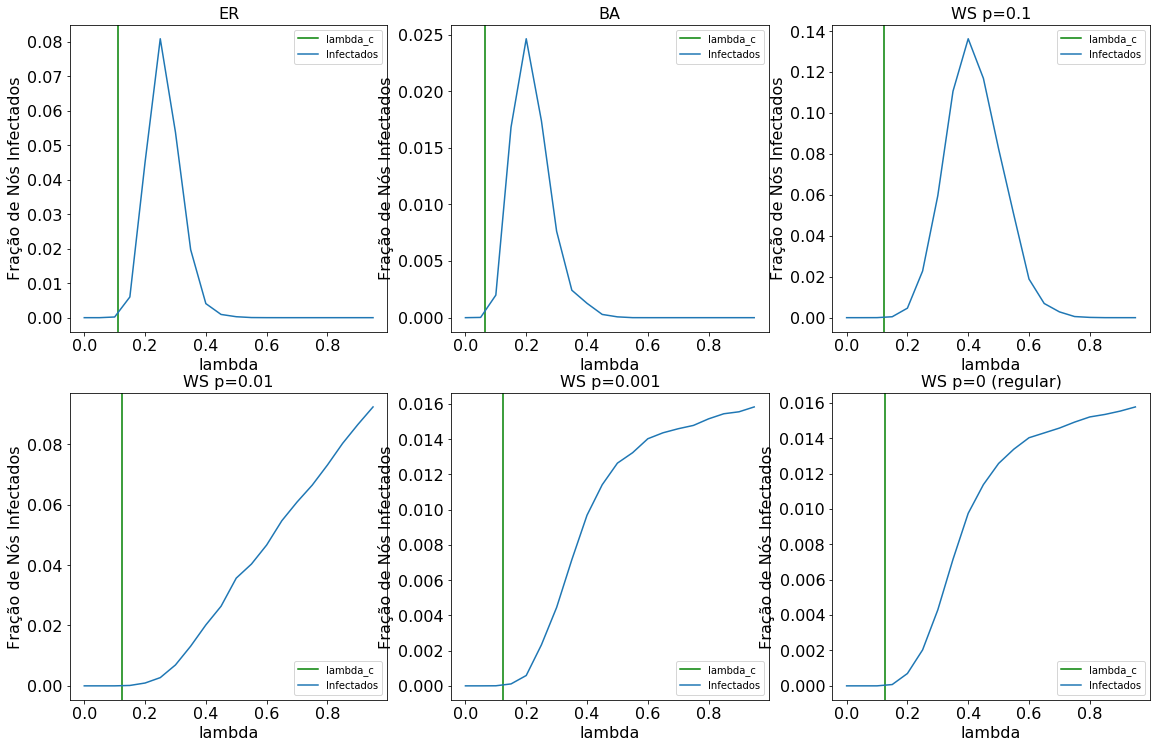

In [6]:
fig, axis = plt.subplots(2,3, figsize=(8,5))
plt.subplots_adjust(right=2, top=2)
n = 0    
l=0
c=0
for g, gtitle in [(er,'ER'),(ba,'BA'),(sw_e1,'WS p=0.1'),(sw_e2,'WS p=0.01'),(sw_e3,'WS p=0.001'),(reg,'WS p=0 (regular)')]:
    axis[l,c].set_xlabel('lambda')
    axis[l,c].set_ylabel('Fração de Nós Infectados')
    axis[l,c].set_title(gtitle)
    set_ax_fontsize(axis[l,c], 16)
    lambda_c = momment_of_degree_distribution(g,1)/momment_of_degree_distribution(g,2)
    axis[l,c].axvline(x=lambda_c, color = 'g', label='lambda_c')
    sns.lineplot(x=lbdaAll, y=I[g], ax=axis[l,c], label='Infectados')
    n = n+1
    l=math.floor(n/3)
    c=n%3

As previsões (lambda_c) foram boas para todas as redes, notamos que no comportamento SIR a infecção pode se isolar caso seja rápida de mais (lambda alto em ER e BA) e aqueles que se recuperaram acabam protegendo parte da rede. Já para alguns lambdas específicos, existe certo equilíbrio e a fração de nós infectados aumenta. Em redes regulares, fica difícil isolar parte da rede, mesmo com a presença de indivíduos recuperados, portanto vemos um aumento constante do grau de infeção em função de lambda para as redes WS, principalmente para aquelas com probabilidade de rewiring baixo (mais regulares), enquanto que as com probabilidade maior (e.g. WS p=0.1) acabam tendo comportamento similar as outras redes onde existe um lambda que maximiza a infecção.

### SIS Analisys

In [45]:
betaRange = np.arange(0,1,0.05)
Tmax = 30
I = dict()
lbdaAll = betaRange # considering mu=1, otherwise it must be divided by mu.
for G in [er, ba, sw_e3, sw_e2, sw_e1, reg]:
        _, I[G] = SISlbda(G, betaRange, mu=1, Tmax=Tmax)

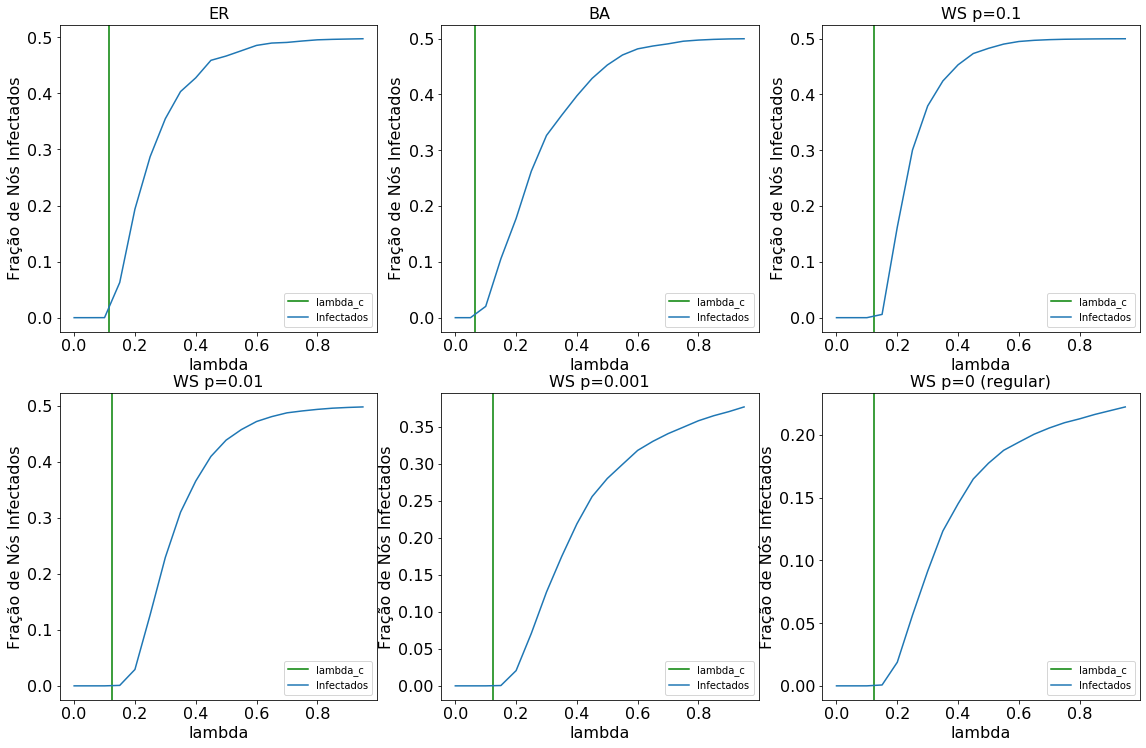

In [46]:
fig, axis = plt.subplots(2,3, figsize=(8,5))
plt.subplots_adjust(right=2, top=2)
n = 0    
l=0
c=0
for g, gtitle in [(er,'ER'),(ba,'BA'),(sw_e1,'WS p=0.1'),(sw_e2,'WS p=0.01'),(sw_e3,'WS p=0.001'),(reg,'WS p=0 (regular)')]:
    axis[l,c].set_xlabel('lambda')
    axis[l,c].set_ylabel('Fração de Nós Infectados')
    axis[l,c].set_title(gtitle)
    set_ax_fontsize(axis[l,c], 16)
    lambda_c = momment_of_degree_distribution(g,1)/momment_of_degree_distribution(g,2)
    axis[l,c].axvline(x=lambda_c, color = 'g', label='lambda_c')
    sns.lineplot(x=lbdaAll, y=I[g], ax=axis[l,c], label='Infectados')
    n = n+1
    l=math.floor(n/3)
    c=n%3

Para o comportamento SIS, notamos que a infecção tende a ser crescente em função de lambda, uma vez que a "bolha de imunidade" presente no comportamento SIR é impossível nesse cenário. Mais uma vez notamos que a predição da alteração de fase em função de lambda se aproxima da situação simulada.

## Exercício 3

In [8]:
## Lendo redes
# Airport
airport = nx.read_edgelist("../datasets/USairport_2010.txt", nodetype=int, data=(('weight',float),))
airport = airport.to_undirected()
airport = max(nx.connected_component_subgraphs(airport), key=len)
airport = nx.convert_node_labels_to_integers(airport, first_label=0)
print("\n\nUSA Airport")
printInfo(airport)

# Hamsterster Friends
ham = nx.read_edgelist('../datasets/hamsterster', comments='%')
ham = max(nx.connected_component_subgraphs(ham), key=len)
ham = ham.to_undirected()
ham = nx.convert_node_labels_to_integers(ham, first_label=0)
print("\n\nHamsterster Friends")
printInfo(ham)

# c-elegans neural
celegans = nx.read_edgelist('../datasets/C-elegans-frontal.txt')
celegans = celegans.to_undirected()
celegans = max(nx.connected_component_subgraphs(celegans), key=len)
celegans = nx.convert_node_labels_to_integers(celegans, first_label=0)
print("\n\nC-Elegans")
print("Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html\nA versao em .gml estava dando erro.")
printInfo(celegans)




USA Airport
Nós: 1572
Arestas: 17214
Grau Médio: 21.900763358778626


Hamsterster Friends
Nós: 1788
Arestas: 12476
Grau Médio: 13.955257270693512


C-Elegans
Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html
A versao em .gml estava dando erro.
Nós: 131
Arestas: 687
Grau Médio: 10.488549618320612


In [ ]:
nRecoveredByNode = dict()
for g in [airport, ham, celegans]:
    print("-")
    nRecoveredByNode[g] = SIRNodesRecovered(g, beta=0.4, mu=1, Tmax=50, rep=30)


-


In [111]:
d = dict()
cc = dict()
kc= dict()
bc = dict()
ec = dict()
pr = dict()
com = dict()
pdCorr = dict()
for g in [airport, ham, celegans]:
    d[g] = degrees(g)
    cc[g] = closenessCentrality(g)
    kc[g] = kCore(g)
    bc[g] = betweenessCentrality(g)
    ec[g] = eigenVectorCentrality(g,1000)
    pr[g] = pageRank(g)
    com[g] = communicabilityCentrality(g)
    


In [112]:
for g in [airport, ham, celegans]:
    pdCorr[g] = dict()
    for fname, feature in [("Betweeness Centrality", bc),("Closeness Centrality",cc),("Communicability Centrality",com),("Degree",d),\
               ("EigenVector Centrality",ec), ('K-Core',kc) ,("Page Rank",pr)]:
        pdCorr[g][fname] = feature[g].corr(pd.Series(nRecoveredByNode[g]),method="spearman")

## Airport

Como podemos ver pelas figuras e o teste de Spearman o grau e o k-core parecem bem relacionados a quantidade de nós infectados.
No entanto, essa inflencia parece ser similar a uma função degrau, onde a partir de um certo limiar a infecção atinge seu potencial máximo, mas abaixo desse limiar, o nó de origem não prediz a capacidade da infecção/rumor se expandir. Por exemplo, sempre quue a infecção começa em um nó com k-core maior que 30, a infecção atinge seu limiar de 60% de recuperados.
Uma possibilidade para esse comportamento é a limitação de 20 épocas usada apra evitar demora nas simulações.

In [113]:
for fname, tabs in [("Betweeness Centrality", "\t"),("Closeness Centrality","\t\t"),("Communicability Centrality","\t"),("Degree","\t\t\t"),\
               ("EigenVector Centrality","\t"), ('K-Core',"\t\t\t") ,("Page Rank","\t\t\t")]:
    print(fname,":",tabs,str(round(pdCorr[airport][fname],5)))

Betweeness Centrality : 	 0.7797
Closeness Centrality : 		 0.72606
Communicability Centrality : 	 0.66778
Degree : 			 0.95542
EigenVector Centrality : 	 0.6678
K-Core : 			 0.95761
Page Rank : 			 0.72924


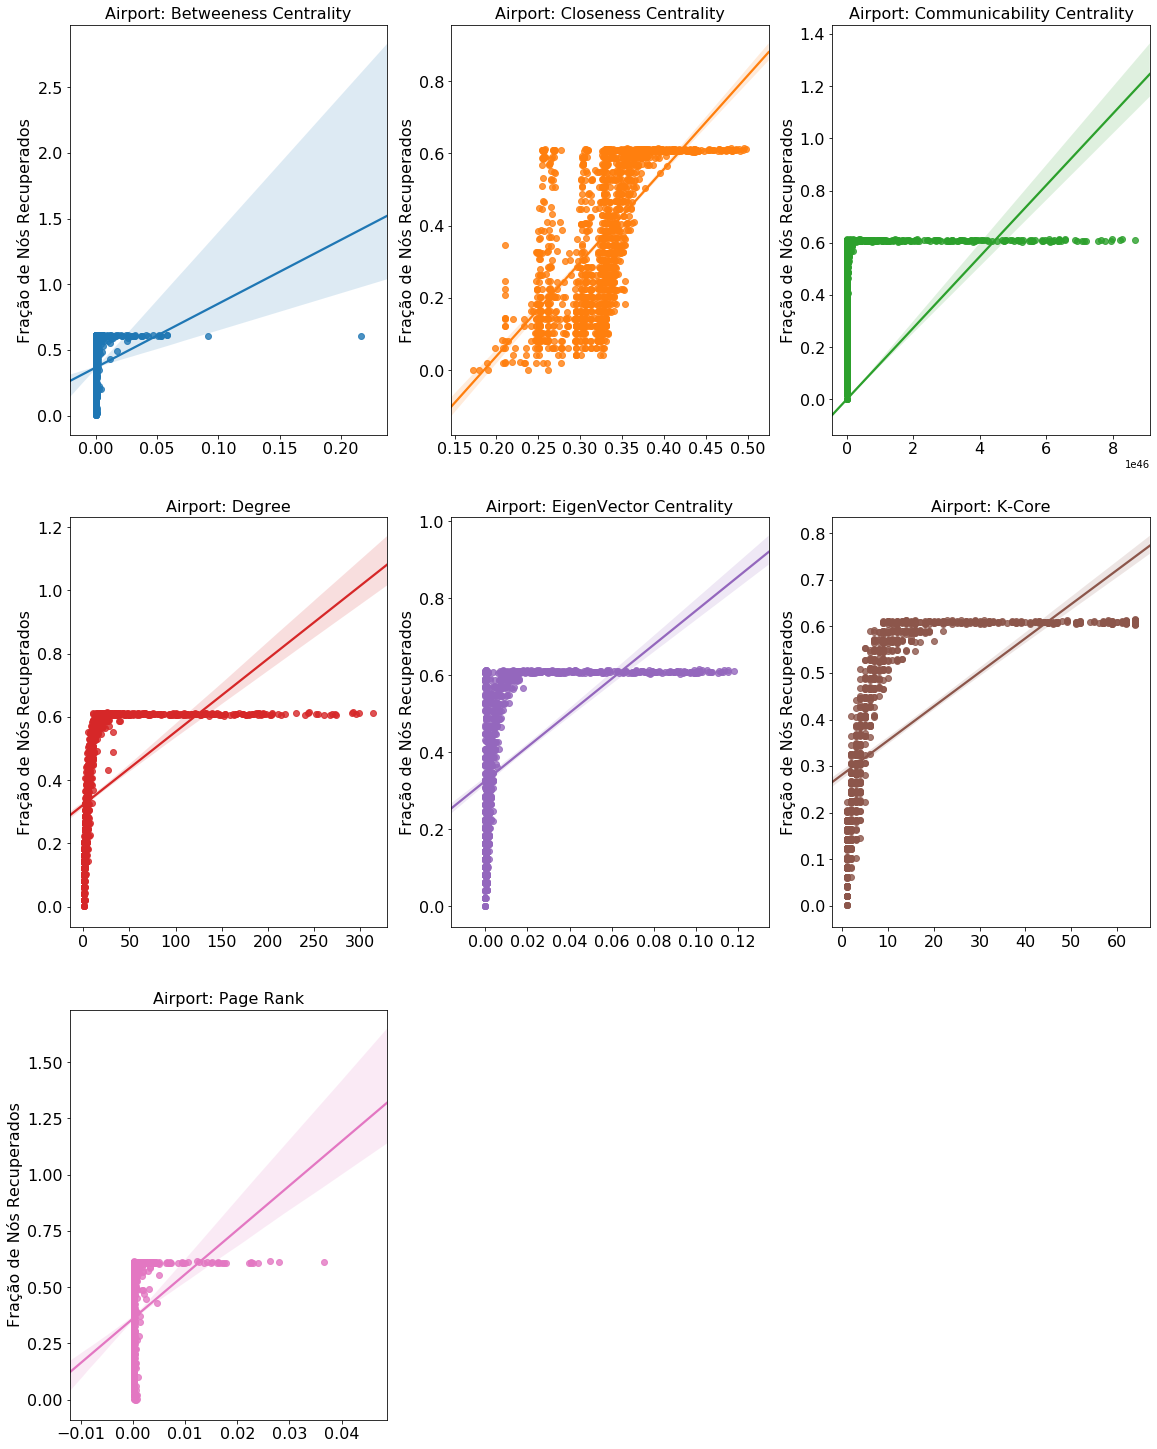

In [114]:
g= airport
fig, axis = plt.subplots(3,3, figsize=(8,5))
plt.subplots_adjust(right=2, top=4)
n = 0    
l=0
c=0
for axisName, feature in [("Betweeness Centrality", bc),("Closeness Centrality",cc),("Communicability Centrality",com),("Degree",d),\
               ("EigenVector Centrality",ec), ('K-Core',kc) ,("Page Rank",pr)]:
    axis[l,c].set_xlabel(axisName)
    axis[l,c].set_ylabel('Fração de Nós Recuperados')
    axis[l,c].set_title("Airport: "+axisName)
    set_ax_fontsize(axis[l,c], 16)
    lambda_c = momment_of_degree_distribution(g,1)/momment_of_degree_distribution(g,2)
    sns.regplot(x=feature[g], y=nRecoveredByNode[g], ax=axis[l,c], label=axisName)
    n = n+1
    l=math.floor(n/3)
    c=n%3
    
axis[2,1].remove()
axis[2,2].remove()

## Hamsterer

De modo similar a rede de aeroportos, o K-Core e o Grau dos nós fonte são mais preditivos sobre o qanto a infecção irá se espalhar na rede. Mas temos um comportamento mais suave nas transições, principalmente nesses dois atribuutos.

In [115]:
for fname, tabs in [("Betweeness Centrality", "\t"),("Closeness Centrality","\t\t"),("Communicability Centrality","\t"),("Degree","\t\t\t"),\
               ("EigenVector Centrality","\t"), ('K-Core',"\t\t\t") ,("Page Rank","\t\t\t")]:
    print(fname,":",tabs,str(round(pdCorr[ham][fname],5)))

Betweeness Centrality : 	 0.77673
Closeness Centrality : 		 0.82779
Communicability Centrality : 	 0.82264
Degree : 			 0.95626
EigenVector Centrality : 	 0.82268
K-Core : 			 0.95732
Page Rank : 			 0.86564


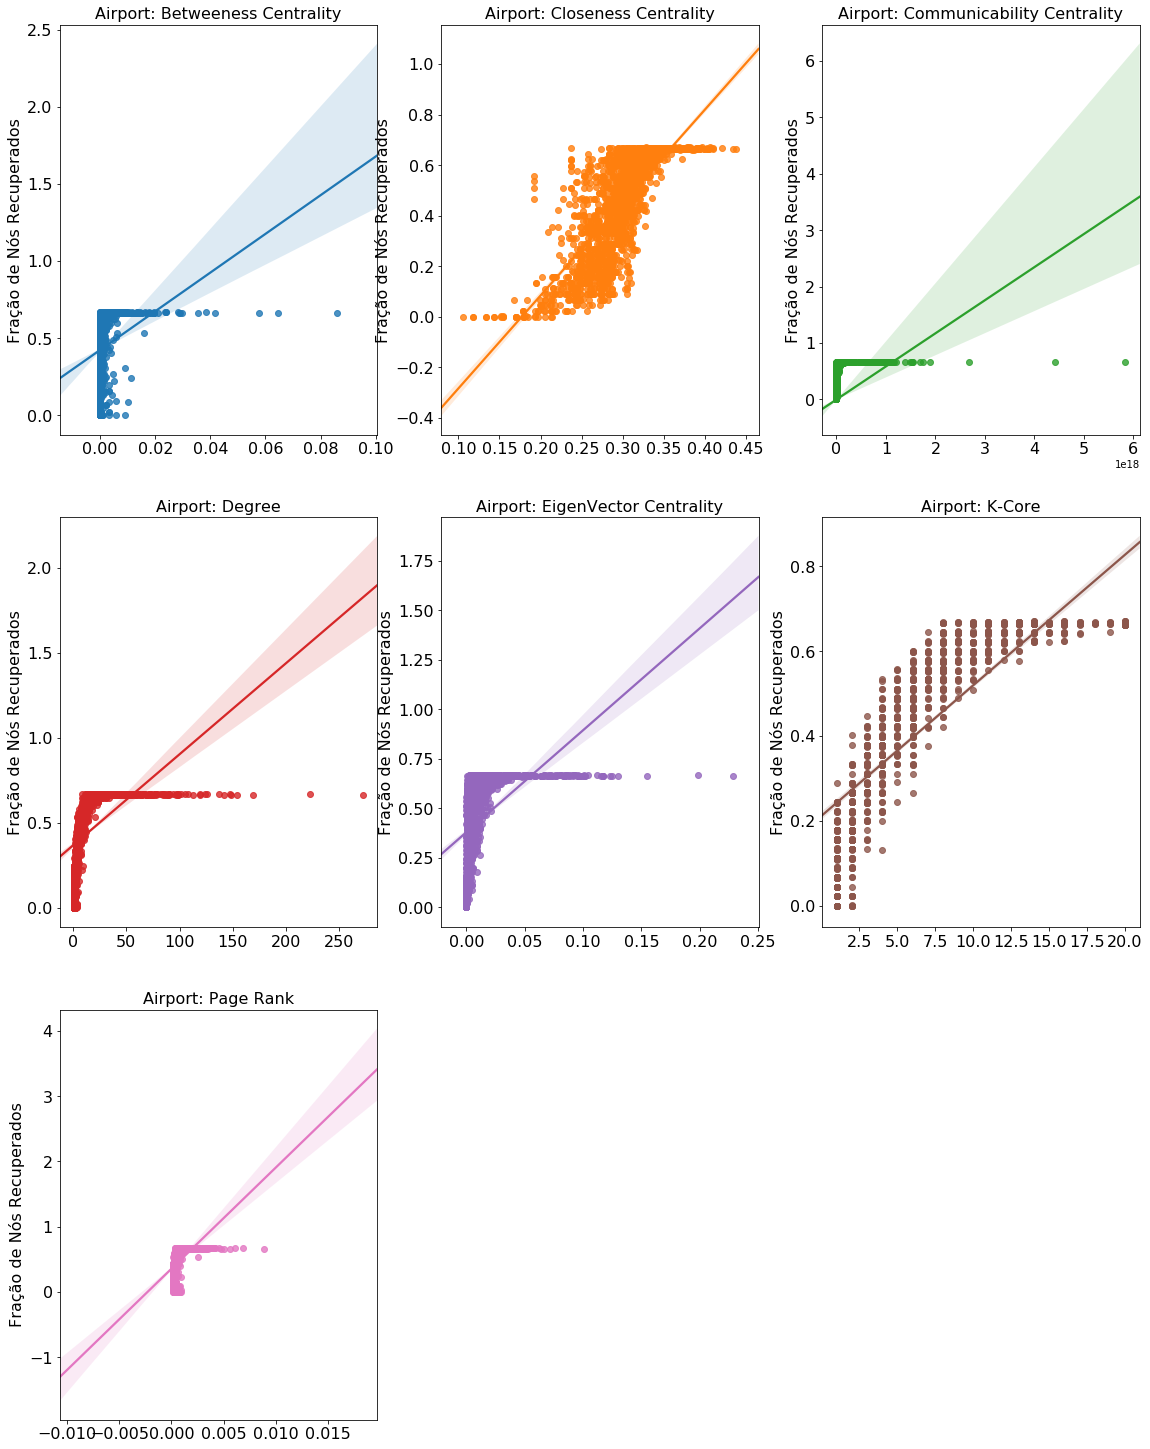

In [116]:
g= ham
fig, axis = plt.subplots(3,3, figsize=(8,5))
plt.subplots_adjust(right=2, top=4)
n = 0    
l=0
c=0
for axisName, feature in [("Betweeness Centrality", bc),("Closeness Centrality",cc),("Communicability Centrality",com),("Degree",d),\
               ("EigenVector Centrality",ec), ('K-Core',kc) ,("Page Rank",pr)]:
    axis[l,c].set_xlabel(axisName)
    axis[l,c].set_ylabel('Fração de Nós Recuperados')
    axis[l,c].set_title("Airport: "+axisName)
    set_ax_fontsize(axis[l,c], 16)
    lambda_c = momment_of_degree_distribution(g,1)/momment_of_degree_distribution(g,2)
    sns.regplot(x=feature[g], y=nRecoveredByNode[g], ax=axis[l,c], label=axisName)
    n = n+1
    l=math.floor(n/3)
    c=n%3
    
axis[2,1].remove()
axis[2,2].remove()

## Celegans

Na rede celegans, podemos ver curvas mais suaves.
K-core e grau ainda são mais relevantes, mas podemos notar algmas correlações não lineares, por exemplo ao ver os gráficos de page-rank e eigenvector centrality.

In [117]:
for fname, tabs in [("Betweeness Centrality", "\t"),("Closeness Centrality","\t\t"),("Communicability Centrality","\t"),("Degree","\t\t\t"),\
               ("EigenVector Centrality","\t"), ('K-Core',"\t\t\t") ,("Page Rank","\t\t\t")]:
    print(fname,":",tabs,str(round(pdCorr[ham][fname],5)))

Betweeness Centrality : 	 0.77673
Closeness Centrality : 		 0.82779
Communicability Centrality : 	 0.82264
Degree : 			 0.95626
EigenVector Centrality : 	 0.82268
K-Core : 			 0.95732
Page Rank : 			 0.86564


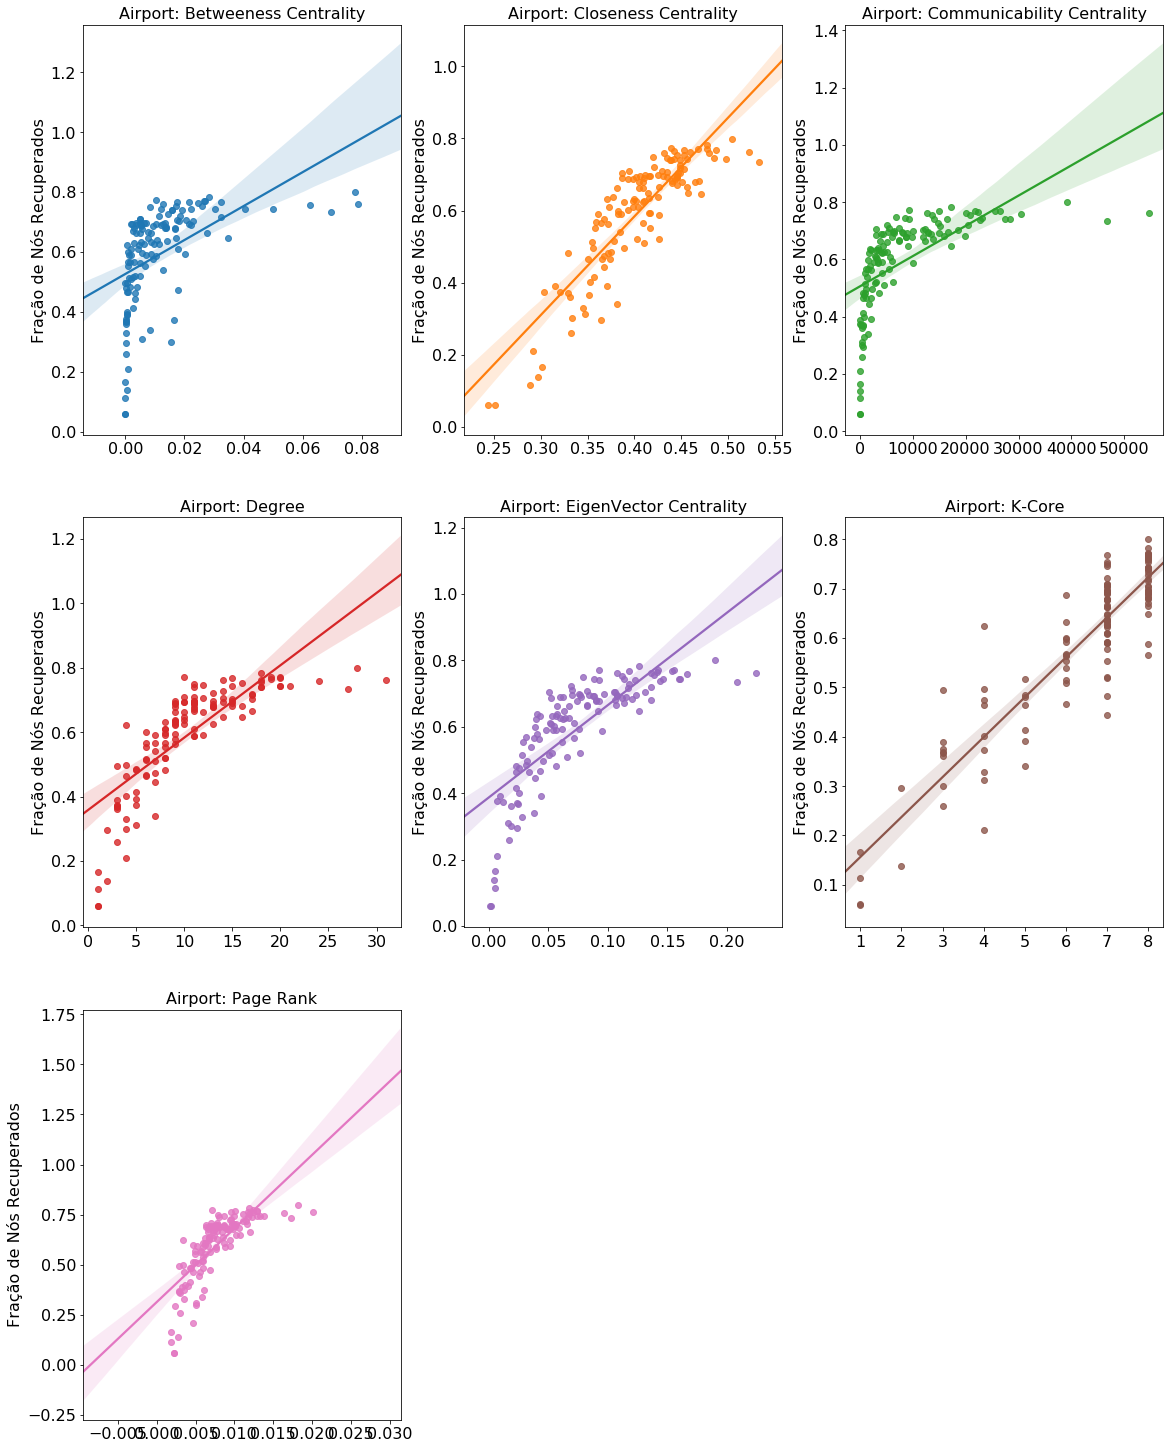

In [118]:
g= celegans
fig, axis = plt.subplots(3,3, figsize=(8,5))
plt.subplots_adjust(right=2, top=4)
n = 0    
l=0
c=0
for axisName, feature in [("Betweeness Centrality", bc),("Closeness Centrality",cc),("Communicability Centrality",com),("Degree",d),\
               ("EigenVector Centrality",ec), ('K-Core',kc) ,("Page Rank",pr)]:
    axis[l,c].set_xlabel(axisName)
    axis[l,c].set_ylabel('Fração de Nós Recuperados')
    axis[l,c].set_title("Airport: "+axisName)
    set_ax_fontsize(axis[l,c], 16)
    lambda_c = momment_of_degree_distribution(g,1)/momment_of_degree_distribution(g,2)
    sns.regplot(x=feature[g], y=nRecoveredByNode[g], ax=axis[l,c], label=axisName)
    n = n+1
    l=math.floor(n/3)
    c=n%3
    
axis[2,1].remove()
axis[2,2].remove()

De modo geral, podemos notar a o impacto do k-core e do grau de um nó fonte na capacidade de uma infecção se espalhar.